# Time Series Models Derived From a Generative Graph

In this notebook, we show how to model and fit a time series model starting from a generative graph. In particular, we explain how to use {func}`scan <pytensor.scan.basic.scan>` to loop efficiently inside a PyMC model.

:::{ .callout-note } 

**Motivation**

Why would we do that, instead of just using {class}`~pymc.distributions.timeseries.AR`? What are the benefits? 

The pre-built time series models in PyMC are very useful and easy to use. Nevertheless, they are not flexible enough to model more complex time series models. By using a generative graph, we can model any time series model we want, as long as we can define it in terms of a generative graph. For example:

- Auto-regressive models with different noise distribution (e.g. {class}`~pymc.distributions.continuous.StudentT` noise).
- Exponential smoothing models.
- ARIMA-GARCH models.
:::

For this example, we consider an autoregressive model AR(2). Recall that an AR(2) model is defined as:

$$
\begin{align*}
y_t &= \rho_1 y_{t-1} + \rho_2 y_{t-2} + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
\end{align*}
$$

That is, we have a recursive linear model in term of the first two lags of the time series.

In [144]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import statsmodels.api as sm

from pymc.pytensorf import collect_default_updates

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%config InlineBackend.figure_format = "retina"

rng = np.random.default_rng(42)

In [145]:
import matplotlib.pyplot as plt
# import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("ticks")
# scale plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

## Define AR(2) Process

We start by encoding the generative graph of the AR(2) model as a function `ar_dist`. The strategy is to pass this function as a custom distribution via {class}`~pymc.CustomDist` inside a PyMC model. 

We need to specify the initial state (`ar_init`), the autoregressive coefficients (`rho`), and the standard deviation of the noise (`sigma`). Given such parameters, we can define the generative graph of the AR(2) model using the  {meth}`scan <pytensor.scan.basic.scan>` operation.

:::{admonition} **What are all of these functions?**
:class: note

At first, it might seem a bit overwhelming to see all these functions. However, they are just helper functions to define the generative graph of the AR(2) model.

- {meth}`~pymc.pytensorf.collect_default_updates` tells PyMC that the random variable (RV) in the generative graph should be updated in every iteration of the loop. If we don't do this, the random states will not update between time steps, and we will sample the same innovations over and over.


- {meth}`scan <pytensor.scan.basic.scan>` is an efficient way to loop inside a PyMC model. It is similar to the `for` loop in Python, but it is optimized for `pytensor`. We need to specify the following arguments:

    - `fn`: The function that defines the transition steep.
    - `outputs_info`: This is the list of variables or dictionaries describing the initial state of the outputs computed recurrently. One common key of this dictionary is `taps`, which specifies the number of previous time steps to keep track of. In this case, we keep track of the last two time steps (lags).
    - `non_sequences`: The list of arguments that are passed to `fn` at each steps. In this case are the autoregressive coefficients and the noise standard deviation of the AR(2) model.
    - `n_steps`: The number of steps to loop.
    - `strict`:  If `True`, all the shared variables used in `fn` must be provided as a part of `non_sequences` or `sequences` (In this example we do not use the argument `sequences`, which is the list of variables or dictionaries describing the sequences `scan` has to iterate over. In this case we can simply loop over the time steps).
:::

Let's see concrete implementations:

In [164]:
lags = 2  # Number of lags
# lags = 1  # Number of lags
timeseries_length = 100  # Time series length


# This is the transition function for the AR(2) model.
# We take as inputs previous steps and then specify the autoregressive relationship.
# Finally, we add Gaussian noise to the model.
# def ar_step(x_tm1, rho, sigma):
#     mu = x_tm1 * rho[0]     ##### I GUESS THIS IS WHERE I COULD PLUG IN MY NEXT_TREE GENERATOR
def ar_step(x_tm2, x_tm1, rho, sigma):
    mu = x_tm1 * rho[0] + x_tm2 * rho[1]     ##### I GUESS THIS IS WHERE I COULD PLUG IN MY NEXT_TREE GENERATOR

    # x = mu + pm.Normal.dist(sigma=sigma)   ##### THE RANDOMNESS IS CONTIBUTED FROM MY RANDOM DRAWS TO NUMPY RANDOM
    x = mu + pm.Uniform.dist()   ##### THE RANDOMNESS IS CONTIBUTED FROM MY RANDOM DRAWS TO NUMPY RANDOM

    # variable = 3
    # # x = mu + (pm.Uniform.dist() < 0.05) * variable
    # x = mu * (pm.Uniform.dist() > 0.05) 

    # y = pm.Uniform.dist()# < 0.1
    # x = x_tm2 + r * (r < 0.2) - (1-r) * (r > 0.8)
    
    # x = (x_tm2 - y) #* (x_tm2 - y)

    return x, collect_default_updates([x])


# Here we actually "loop" over the time series.
def ar_dist(ar_init, rho, sigma, size):
    ar_steps, _ = pytensor.scan(
        fn=ar_step,
        outputs_info=[{"initial": ar_init, "taps": range(-lags, 0)}],
        non_sequences=[rho, sigma],
        n_steps=timeseries_length - lags,
        strict=True,
    )

    return ar_steps

## Generate AR(2) Graph

Now that we have implemented the AR(2) step, we can assign priors to the parameters `rho`, `sigma` and the initial state `ar_init`.

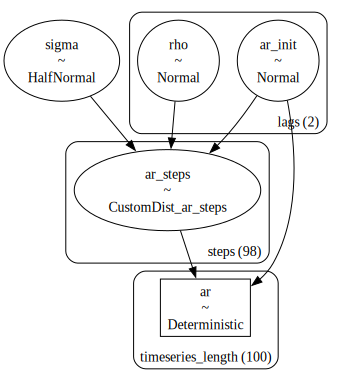

In [165]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(timeseries_length - lags),
    "timeseries_length": range(timeseries_length),
}
with pm.Model(coords=coords, check_bounds=False) as model:
    rho = pm.Normal(name="rho", mu=0, sigma=0.2, dims=("lags",))
    sigma = pm.HalfNormal(name="sigma", sigma=0.2)

    ar_init = pm.Normal(name="ar_init", sigma=0.5, dims=("lags",))

    ar_steps = pm.CustomDist(
        "ar_steps",
        ar_init,
        rho,
        sigma,
        dist=ar_dist,
        dims=("steps",),
    )

    ar = pm.Deterministic(
        name="ar", var=pt.concatenate([ar_init, ar_steps], axis=-1), dims=("timeseries_length",)
    )


pm.model_to_graphviz(model)

## Prior

Let's sample from the prior distribution to see how the AR(2) model behaves.

In [166]:
with model:
    prior = pm.sample_prior_predictive(samples=500, random_seed=rng)

Sampling: [ar_init, ar_steps, rho, sigma]


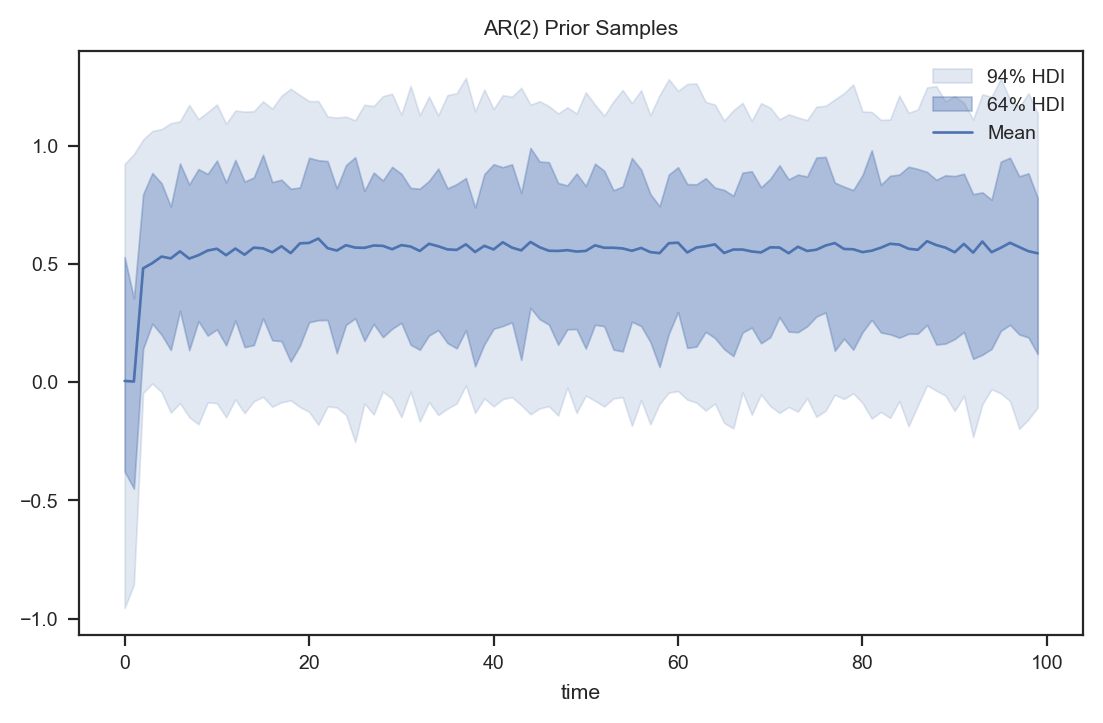

In [167]:
#| label: fig-asdf
#| fig-cap: alksd falskjdf laksjdf laskjdf

_, ax = plt.subplots()
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(prior.prior["ar"], hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=np.arange(timeseries_length),
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(prior.prior["ar"].mean(("chain", "draw")), color="C0", label="Mean")
ax.legend(loc="upper right")
ax.set_xlabel("time")
ax.set_title("AR(2) Prior Samples");

It is not surprising that the prior distribution is a stationary process around zero given given that our prior for the `rho` parameter is weakly informative and centered on zero.

Let's look into individual samples to get a feeling of the heterogeneity of the generated series:

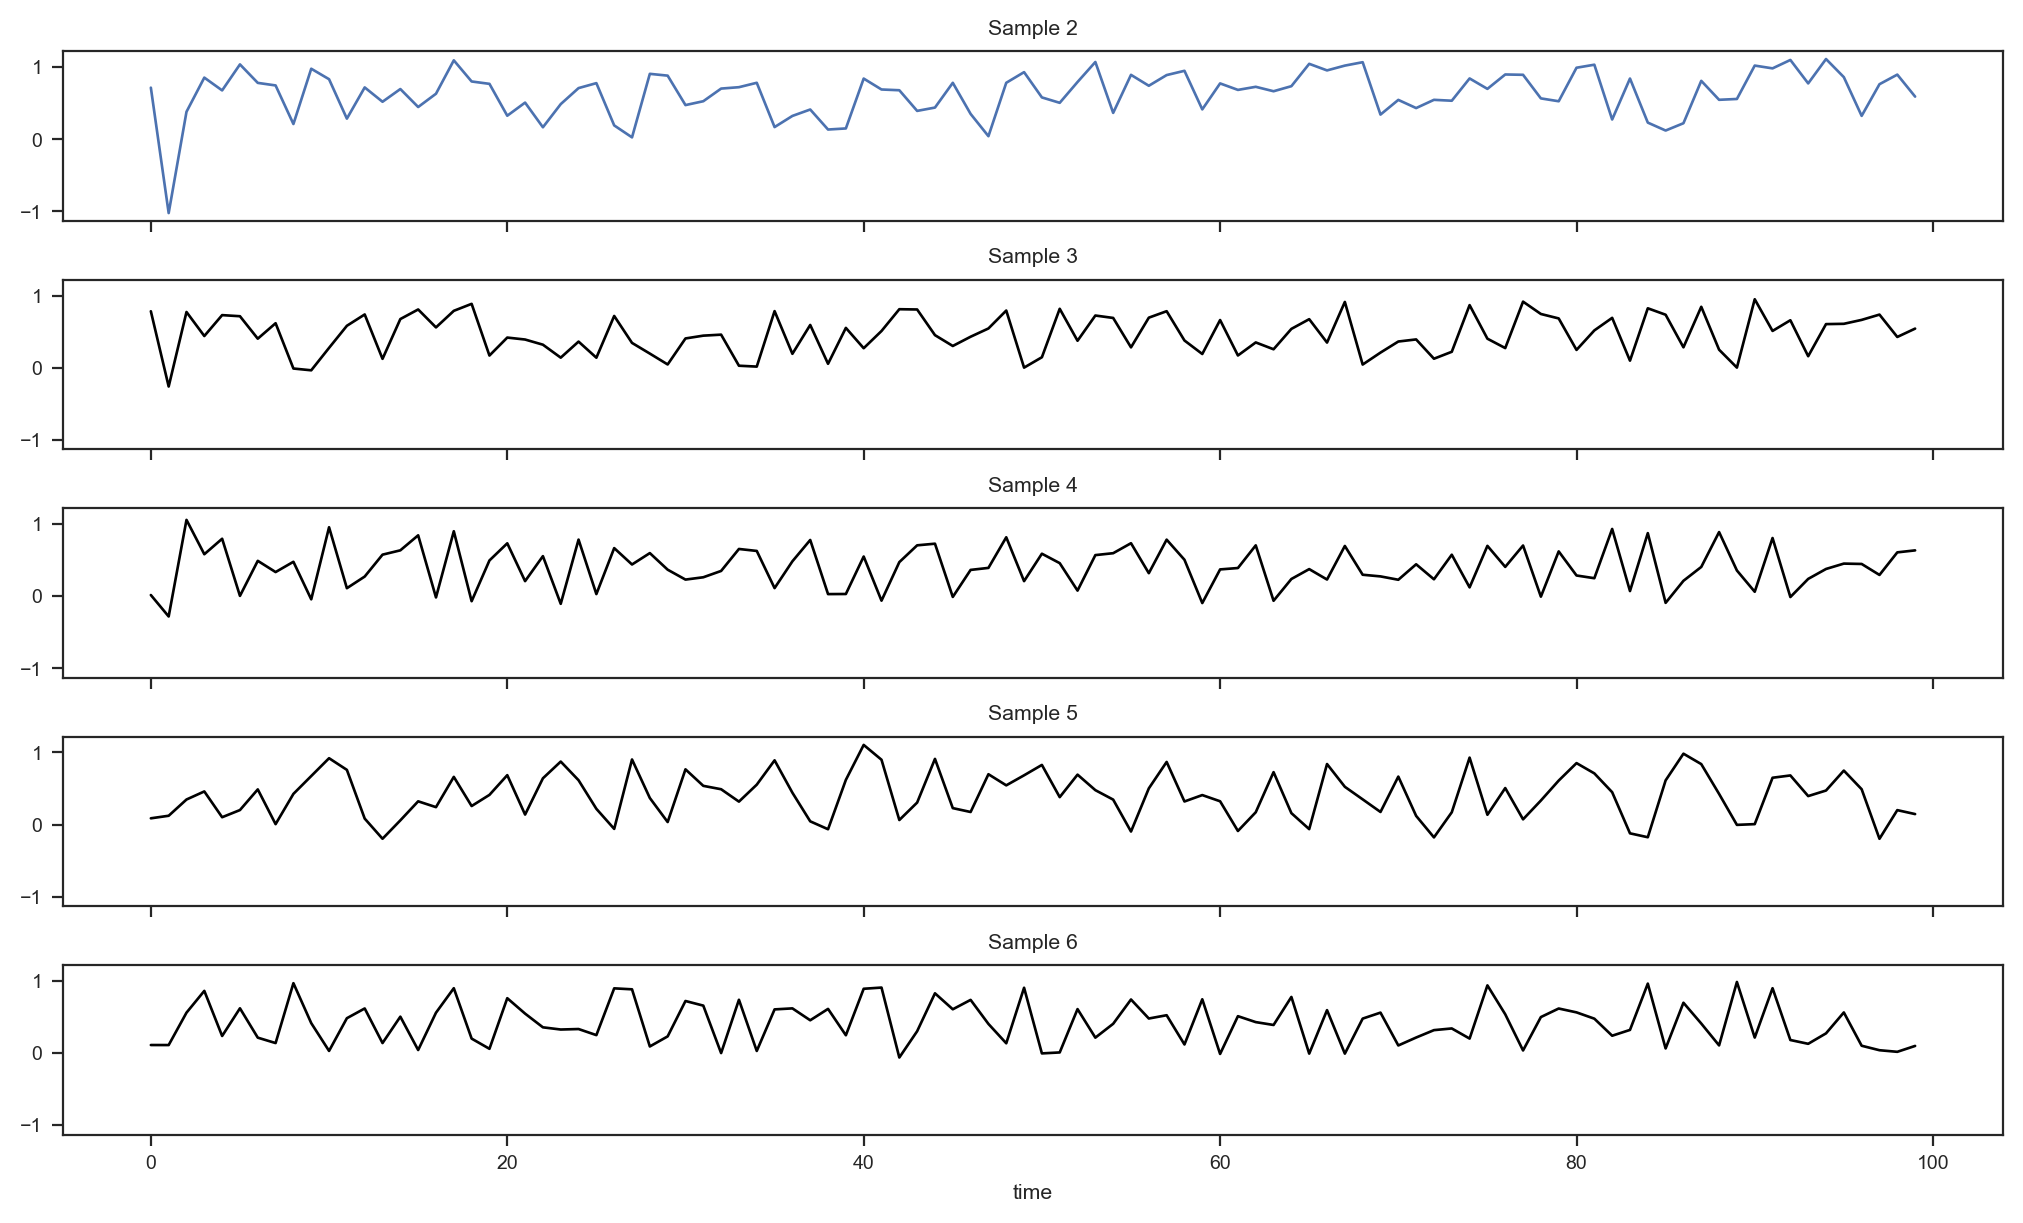

In [168]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(10, 6), sharex=True, sharey=True, layout="constrained"
)
chosen_draw = 2

for i, axi in enumerate(ax, start=chosen_draw):
    axi.plot(
        prior.prior["ar"].isel(draw=i, chain=0),
        color="C0" if i == chosen_draw else "black",
    )
    axi.set_title(f"Sample {i}")
ax[-1].set_xlabel("time");

## Posterior

Next, we want to condition the AR(2) model on some observed data so that we can do a parameter recovery analysis. We use the {meth}`~pymc.model.transform.conditioning.observe` operation.

Tip for using Uniform:
https://stackoverflow.com/questions/72020005/error-when-observing-on-uniform-with-sampled-parameters-in-pymc

In [169]:
# select a random draw from the prior
prior_draw = prior.prior.isel(chain=0, draw=chosen_draw)
test_data = prior_draw["ar_steps"].to_numpy()

with pm.observe(model, {"ar_steps": test_data}) as observed_model:
    trace = pm.sample(chains=4, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'rho': array([-0.31962516, -0.47863477]), 'sigma_log__': array(-1.2736829), 'ar_init': array([0.84856694, 0.41133639])}

Logp initial evaluation results:
{'rho': -2.76, 'sigma': -0.87, 'ar_init': -2.23, 'ar_steps': -inf}
You can call `model.debug()` for more details.

Let's plot the trace and the posterior distribution of the parameters.

In [ ]:
# Get the true values of the parameters from the prior draw
rho_true = prior_draw["rho"].to_numpy()
sigma_true = prior_draw["sigma"].to_numpy()
ar_obs = prior_draw["ar"].to_numpy()

axes = az.plot_trace(
    data=trace,
    var_names=["rho", "sigma"],
    compact=True,
    lines=[
        ("rho", {}, rho_true),
        ("sigma", {}, sigma_true),
    ],
    backend_kwargs={"figsize": (8, 5), "layout": "constrained"},
)
plt.gcf().suptitle("AR(2) Model Trace");

In [ ]:
axes = az.plot_posterior(
    trace, var_names=["rho", "sigma"], ref_val=[*rho_true, sigma_true], figsize=(8, 3)
)
plt.gcf().suptitle("AR(2) Model Parameters Posterior");

We see we have successfully recovered the true parameters of the model.

## Posterior Predictive

Finally, we can use the posterior samples to generate new data from the AR(2) model. We can then compare the generated data with the observed data to check the goodness of fit of the model.

In [170]:
with observed_model:
    post_pred = pm.sample_posterior_predictive(trace, random_seed=rng)

Sampling: [ar_steps]


/Users/kmt/miniconda3/envs/pymc/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

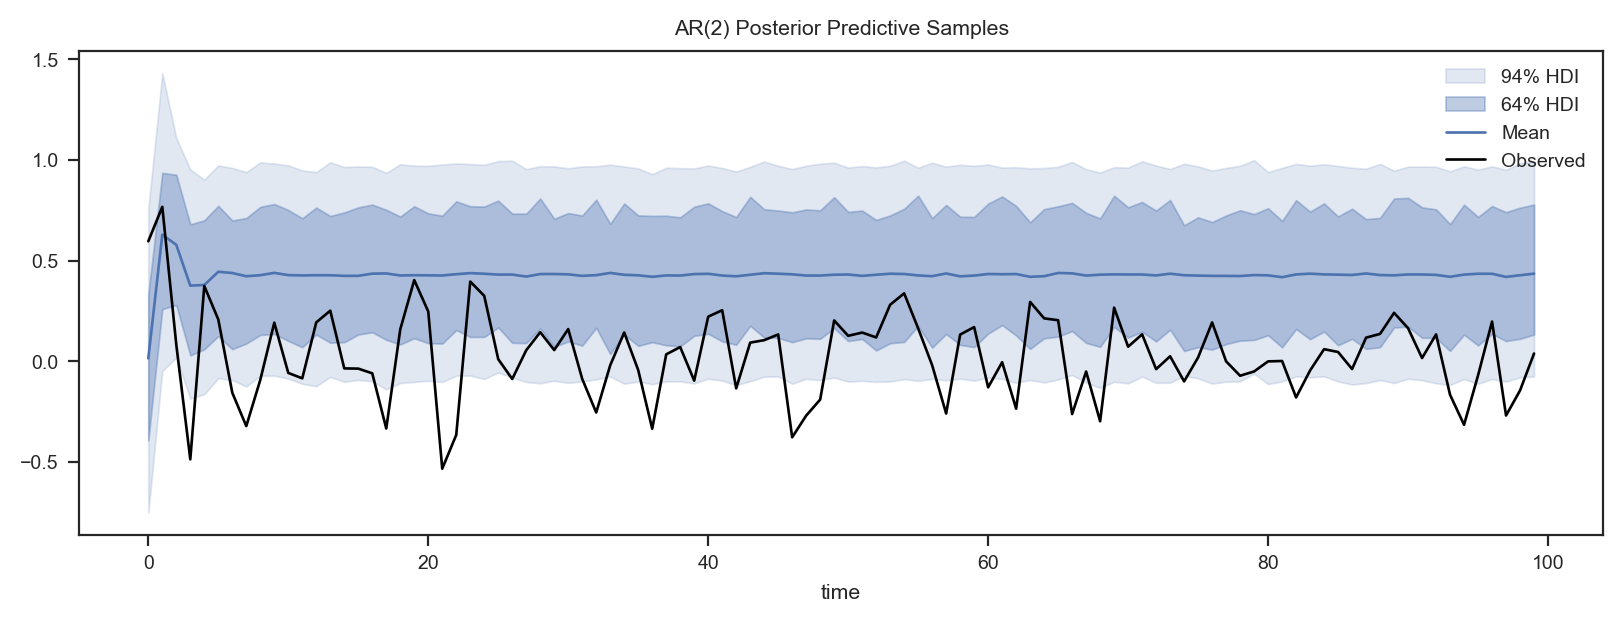

In [171]:
post_pred_ar = post_pred.posterior_predictive["ar"]

_, ax = plt.subplots(figsize=(8, 3))
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=post_pred_ar["timeseries_length"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C0",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(
    post_pred_ar["timeseries_length"],
    post_pred_ar.mean(("chain", "draw")),
    color="C0",
    label="Mean",
)
ax.plot(ar_obs, color="black", label="Observed")
ax.legend(loc="upper right")
ax.set_xlabel("time")
ax.set_title("AR(2) Posterior Predictive Samples");

Overall, we see the model is capturing the global dynamics of the time series. In order to have a better insight of the model, we can plot a subset of the posterior samples and compare them with the observed data.

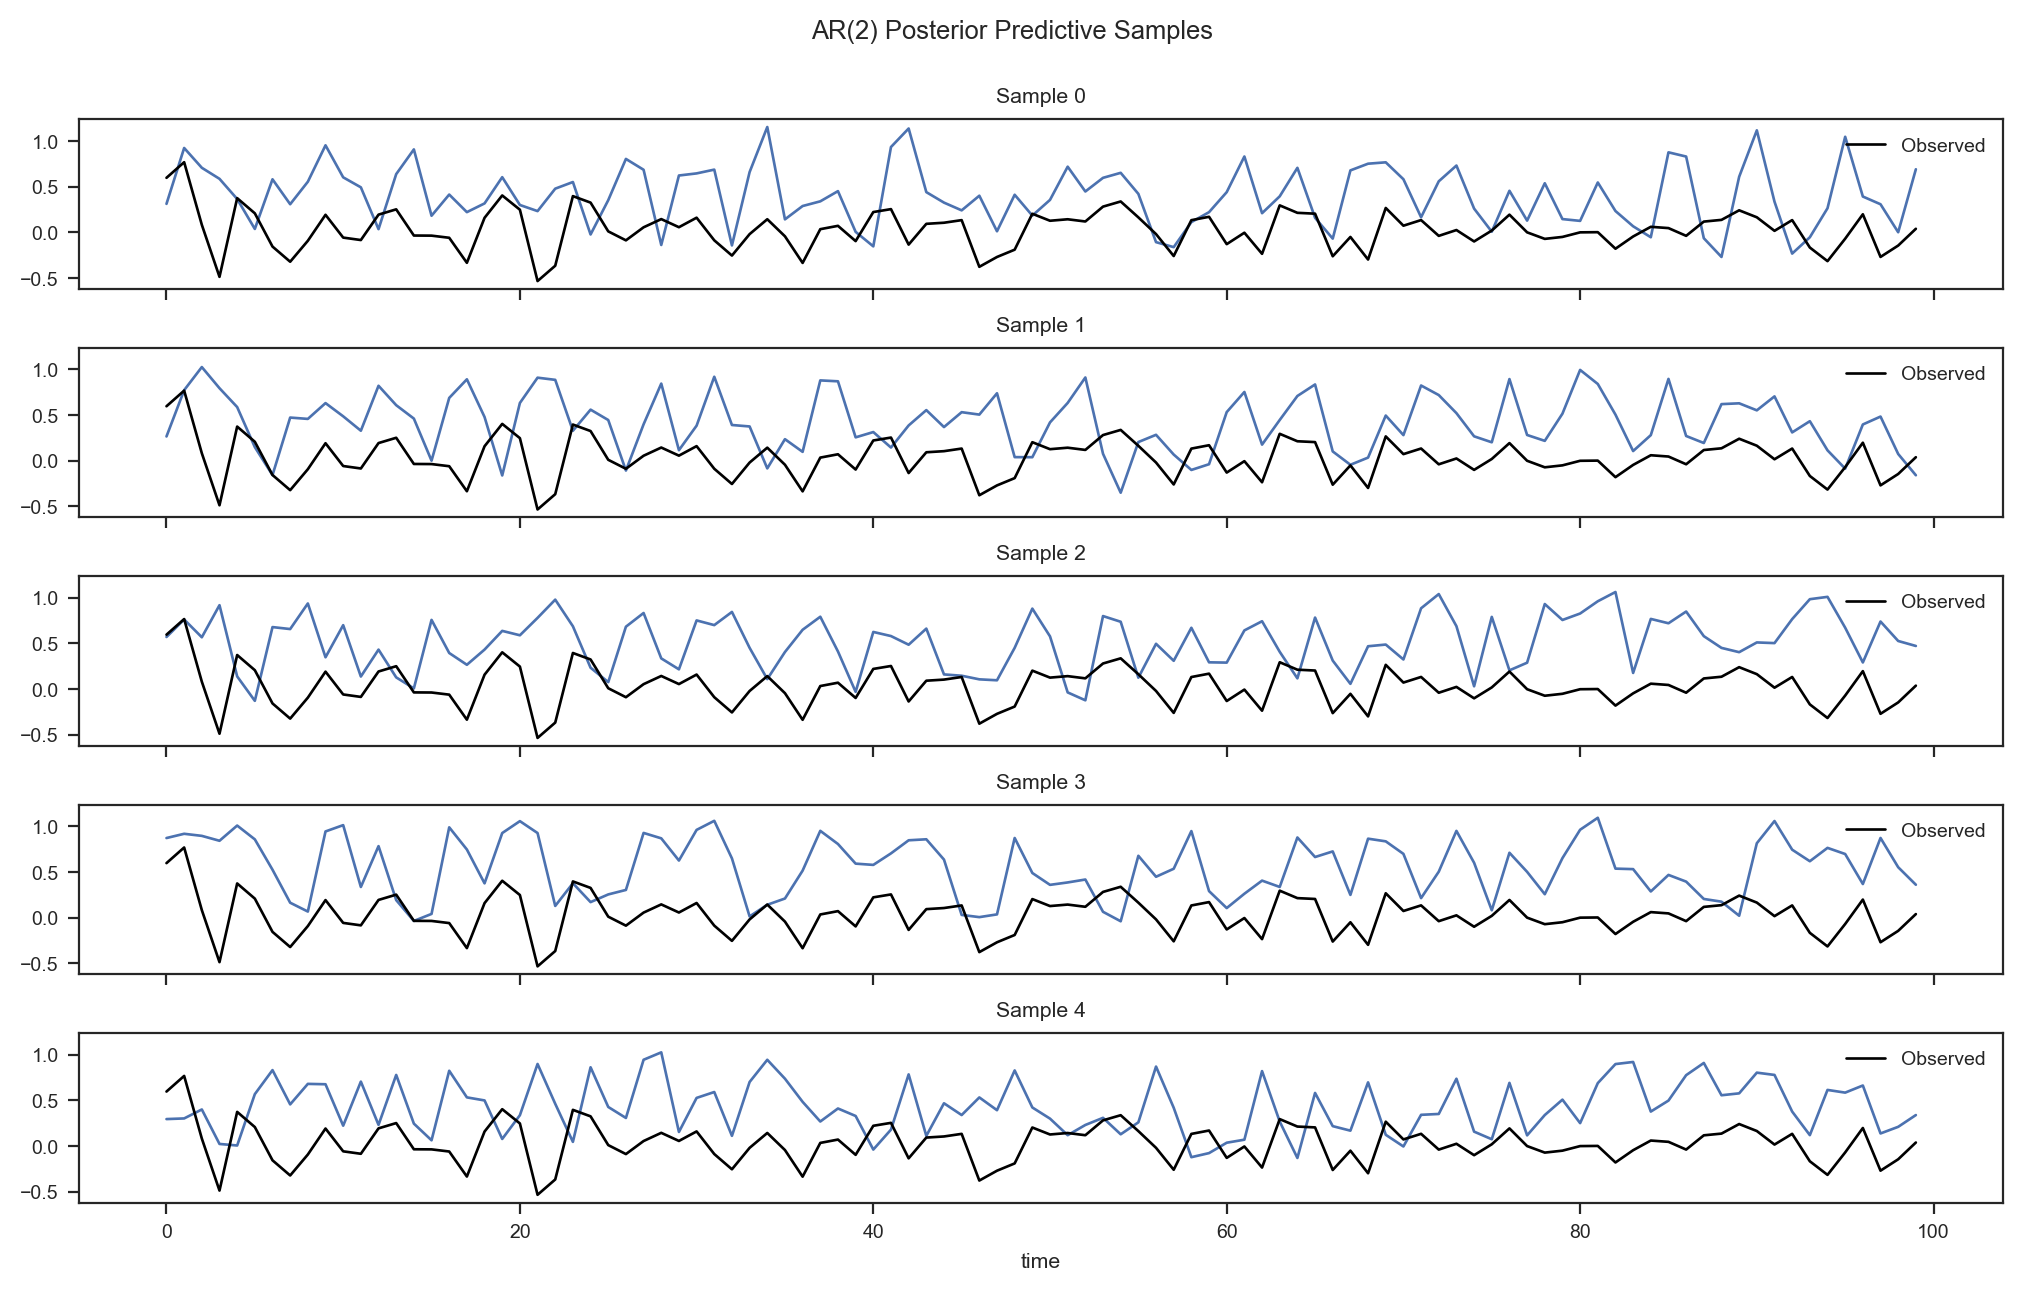

In [172]:
fig, ax = plt.subplots(
    nrows=5, ncols=1, figsize=(10, 6), sharex=True, sharey=True, layout="constrained"
)
for i, axi in enumerate(ax):
    axi.plot(post_pred.posterior_predictive["ar"].isel(draw=i, chain=0), color="C0")
    axi.plot(ar_obs, color="black", label="Observed")
    axi.legend(loc="upper right")
    axi.set_title(f"Sample {i}")

ax[-1].set_xlabel("time")

fig.suptitle("AR(2) Posterior Predictive Samples", y=1.05);

:::{admonition} **Conditional and Unconditional Posteriors**
:class: warning

Many users will be surprised by this posterior because they are used to seeing conditional one-step forecasts, that is 

$$
P(x_{t} \: | \: \{ x_{\tau} \}_{\tau = 1} ^{t - 1})
$$


(what you get in statsmodels/stata/everything), which are much tighter and follow the data more closely.

:::

Let's see how to do this in PyMC! The key observation is that we need to pass the observed data explicitly into out "for loop" in the generative graph. That is, we need to pass it into the {meth}`scan <pytensor.scan.basic.scan>` function.

In [173]:
def conditional_ar_dist(y_data, rho, sigma, size):
    # Here we condition on the observed data by passing it through the `sequences` argument.
    ar_steps, _ = pytensor.scan(
        fn=ar_step,
        sequences=[{"input": y_data, "taps": list(range(-lags, 0))}],
        non_sequences=[rho, sigma],
        n_steps=timeseries_length - lags,
        strict=True,
    )

    return ar_steps

Then we can simply generate samples from the posterior predictive distribution. Observe we need to "rewrite" the generative graph to include the conditioned transition step. When you call {meth}`~pm.sample_posterior_predictive`,PyMC will attempt to match the names of random variables in the active model context to names in the provided `idata.posterior`. If a match is found, the specified model prior is ignored, and replaced with draws from the posterior. This means we can put any prior we want on these parameters, because it will be ignored. We choose {class}`~pymc.distributions.continuous.Flat` because you cannot sample from it. This way, if PyMC does not find a match for one of our priors, we will get an error to let us know something isn't right. For a detailed explanation on these type of cross model predictions, see the great blog post [Out of model predictions with PyMC](https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/).

```{warning}
We need to shift the coordinate `steps` forward by one! The reasons is that the data at (for example) `step=1` is used to create the prediction for `step=2`. If one does not do the shift, the `step=0` prediction will be mislabeled as `step=0`, and the model will look better than it is. 
```

In [174]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(-1, timeseries_length - lags - 1),  # <- Coordinate shift!
    "timeseries_length": range(1, timeseries_length + 1),  # <- Coordinate shift!
}
with pm.Model(coords=coords, check_bounds=False) as conditional_model:
    y_data = pm.Data("y_data", ar_obs)
    rho = pm.Flat(name="rho", dims=("lags",))
    sigma = pm.Flat(name="sigma")

    ar_steps = pm.CustomDist(
        "ar_steps",
        y_data,
        rho,
        sigma,
        dist=conditional_ar_dist,
        dims=("steps",),
    )

    ar = pm.Deterministic(
        name="ar", var=pt.concatenate([ar_init, ar_steps], axis=-1), dims=("timeseries_length",)
    )

    post_pred_conditional = pm.sample_posterior_predictive(trace, var_names=["ar"], random_seed=rng)

Sampling: [ar_steps]


/Users/kmt/miniconda3/envs/pymc/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Let's visualize the conditional posterior predictive distribution and compare it with the `statsmodels` result:

In [175]:
# PyMC conditional posterior predictive samples
conditional_post_pred_ar = post_pred_conditional.posterior_predictive["ar"]

# Statsmodels AR(2) model
mod = sm.tsa.ARIMA(ar_obs, order=(2, 0, 0))
res = mod.fit()

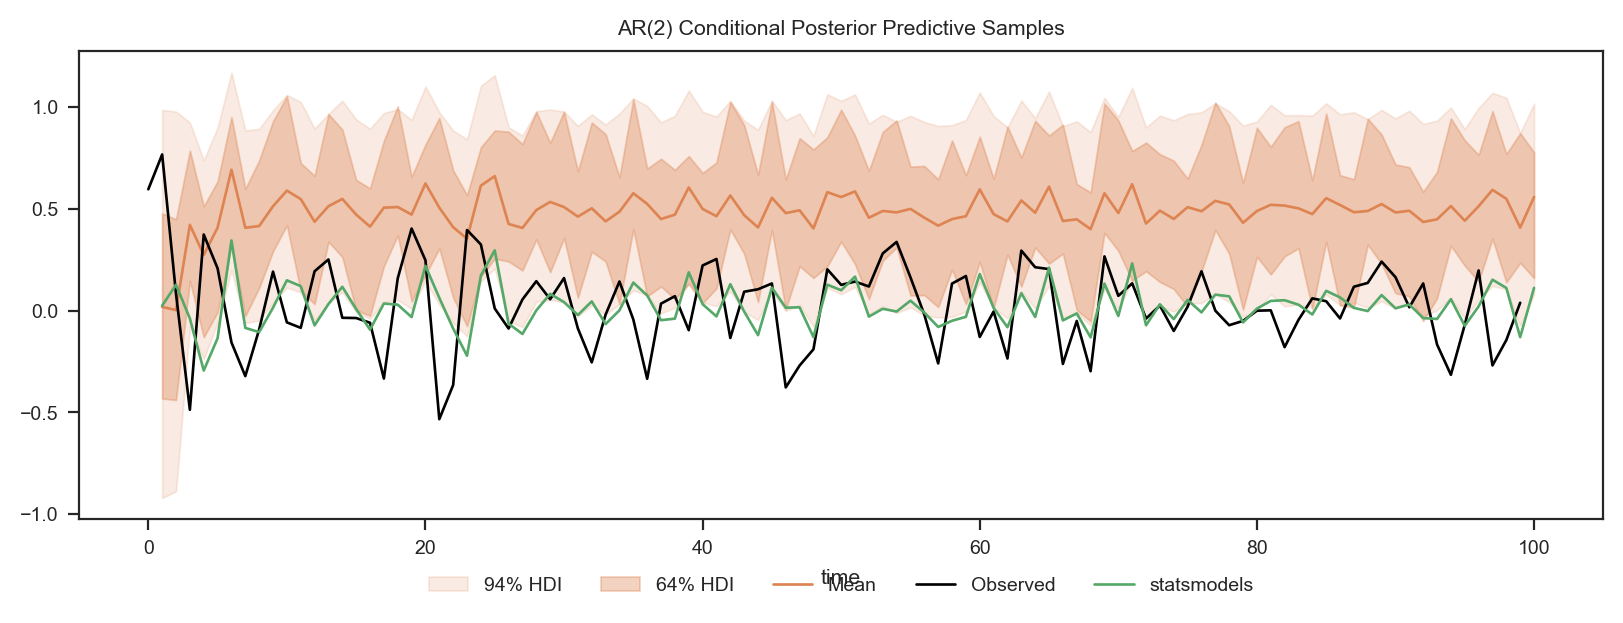

In [176]:
_, ax = plt.subplots(figsize=(8, 3))
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(conditional_post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=conditional_post_pred_ar["timeseries_length"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C1",
        label=f"{hdi_prob:.0%} HDI",
    )
ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    conditional_post_pred_ar.mean(("chain", "draw")),
    color="C1",
    label="Mean",
)
ax.plot(ar_obs, color="black", label="Observed")
ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    res.fittedvalues,
    color="C2",
    label="statsmodels",
)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=5)
ax.set_xlabel("time")
ax.set_title("AR(2) Conditional Posterior Predictive Samples");

We indeed see that these credible intervals are tighter than the unconditional ones.

Here are some additional remarks:

- There's no prediction for $y_0$, because we don't observe $y_{t - 1}$. 
- The predictions seem to "chase" the data, since that's exactly what we're doing. At each step, we reset to the observed data and make one prediction.

```{note}
Relative to the `statsmodels` reference, we're just a little different in the initialization. This makes sense, since they do some fancy MLE initialization trickery and we estimate it as a parameter. The difference should wash out as we iterate over the sequence, and we see that indeed it does.
```

## Out of Sample Predictions

In this last section, wee describe how to generate out-of-sample predictions.

In [177]:
# Specify the number of steps to forecast
forecast_steps = 10

The idea is to use the posterior samples and the latest available two data points (because we have an AR(2) model) to generate the forecast:

In [178]:
coords = {
    "lags": range(-lags, 0),
    "steps": range(timeseries_length, timeseries_length + forecast_steps),
}
with pm.Model(coords=coords, check_bounds=False) as forecasting_model:
    forecast_initial_state = pm.Data("forecast_initial_state", ar_obs[-lags:], dims=("lags",))
    rho = pm.Flat(name="rho", dims=("lags",))
    sigma = pm.Flat(name="sigma")

    def ar_dist_forecasting(forecast_initial_state, rho, sigma, size):
        ar_steps, _ = pytensor.scan(
            fn=ar_step,
            outputs_info=[{"initial": forecast_initial_state, "taps": range(-lags, 0)}],
            non_sequences=[rho, sigma],
            n_steps=forecast_steps,
            strict=True,
        )
        return ar_steps

    ar_steps = pm.CustomDist(
        "ar_steps",
        forecast_initial_state,
        rho,
        sigma,
        dist=ar_dist_forecasting,
        dims=("steps",),
    )

    post_pred_forecast = pm.sample_posterior_predictive(
        trace, var_names=["ar_steps"], random_seed=rng
    )

Sampling: [ar_steps]


/Users/kmt/miniconda3/envs/pymc/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

We can visualize the out-of-sample predictions and compare thee results wth the one from  `statsmodels`.

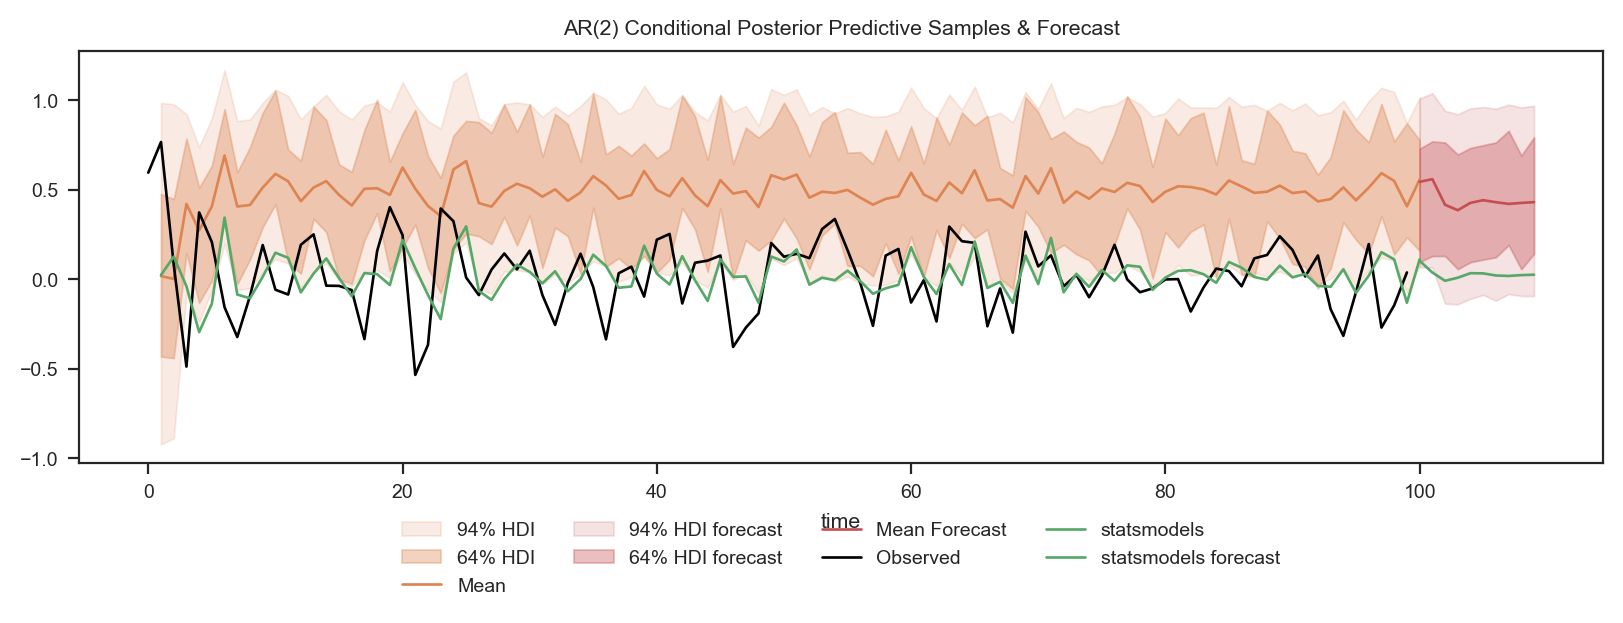

In [179]:
forecast_post_pred_ar = post_pred_forecast.posterior_predictive["ar_steps"]

_, ax = plt.subplots(figsize=(8, 3))
for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(conditional_post_pred_ar, hdi_prob=hdi_prob)["ar"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=conditional_post_pred_ar["timeseries_length"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C1",
        label=f"{hdi_prob:.0%} HDI",
    )

ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    conditional_post_pred_ar.mean(("chain", "draw")),
    color="C1",
    label="Mean",
)

for i, hdi_prob in enumerate((0.94, 0.64), 1):
    hdi = az.hdi(forecast_post_pred_ar, hdi_prob=hdi_prob)["ar_steps"]
    lower = hdi.sel(hdi="lower")
    upper = hdi.sel(hdi="higher")
    ax.fill_between(
        x=forecast_post_pred_ar["steps"],
        y1=lower,
        y2=upper,
        alpha=(i - 0.2) * 0.2,
        color="C3",
        label=f"{hdi_prob:.0%} HDI forecast",
    )

ax.plot(
    forecast_post_pred_ar["steps"],
    forecast_post_pred_ar.mean(("chain", "draw")),
    color="C3",
    label="Mean Forecast",
)


ax.plot(ar_obs, color="black", label="Observed")
ax.plot(
    conditional_post_pred_ar["timeseries_length"],
    res.fittedvalues,
    color="C2",
    label="statsmodels",
)
ax.plot(
    forecast_post_pred_ar["steps"],
    res.forecast(forecast_steps),
    color="C2",
    label="statsmodels forecast",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set_xlabel("time")
ax.set_title(
    "AR(2) Conditional Posterior Predictive Samples & Forecast",
);

## Authors
- Authored by [Jesse Grabowski](https://github.com/jessegrabowski), [Juan Orduz](https://juanitorduz.github.io/) and [Ricardo Vieira](https://github.com/ricardoV94) in March 2024

:::{include} ../page_footer.md
:::